In [17]:
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import lr_scheduler
from torchvision import datasets
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

max_epochs=3

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [8]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25, chunks=9,\
               debug=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for chunk in range(chunks):
                X, Y = torch.load('data/images-' + str(chunk) + '.pt'),\
                       torch.load('data/labels-' + str(chunk) + '.pt')
                train = data_utils.TensorDataset(X, Y)
                train_loader = data_utils.DataLoader(train, batch_size=64, shuffle=True)
            
                for inputs, labels in train_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if debug:
                            print(outputs)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train' and scheduler:
                    scheduler.step()

            epoch_loss = running_loss / (chunks*2169)
            epoch_acc = running_corrects.double() / (chunks*2169)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
def summarize(all_outputs, all_labels):
    ''' Display the confusion matrix, ROC AUC score, and call to a function to 
        display ROC and precision-recall curves.
    '''
    _, all_preds = torch.max(all_outputs, 1)
    preds = all_preds.detach().numpy()
    labels = all_labels.detach().numpy()
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    
    print("True negatives: " + str(tn))
    print("False positives: " + str(fp))
    print("False negatives: " + str(fn))
    print("True positives: " + str(tp))
    
    get_curves(all_outputs, all_labels)
    

In [25]:
def get_curves(all_outputs, all_labels):
    ''' Take torch tensors of all model outputs, all model labels
        and display an roc curve and a precision recall curve.
    '''
    sm = nn.Softmax(dim=1)
    roc_preds = sm(all_outputs).detach().numpy()[:,1]
    roc_labels = all_labels.detach().numpy()
    
    auc = roc_auc_score(roc_labels, roc_preds)
    print("Area under ROC curve: " + str(auc))
    
    fpr, tpr, thresholds = roc_curve(roc_labels, roc_preds)
    precision, recall, thresholds = precision_recall_curve(roc_labels, roc_preds)
    
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label='your model')
    plt.plot(np.asarray([.1, .1]), np.asarray([1., 1.]), label='random model')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC curve")
    
    plt.subplot(1,2,2)
    plt.plot(precision, recall, label='your model')
    plt.plot(np.asarray([0.1, 1.0]), np.asarray([.1, .1]), label='random model')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision/recall curve')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

In [5]:
def test_model(model, criterion):
    model.eval()
    X, Y = torch.load('data/images-9.pt'),\
           torch.load('data/labels-9.pt')
    running_loss = 0.0
    running_corrects = 0
    train = data_utils.TensorDataset(X, Y)
    
    all_outputs = []
    all_labels = []
    
    train_loader = data_utils.DataLoader(train, batch_size=64, shuffle=True)
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        all_outputs.append(outputs.cpu())
        all_labels.append(labels.cpu())
            
    loss = running_loss
    acc = running_corrects.double() / (len(Y))

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(
        loss, acc))
    
    all_outputs = torch.cat((*all_outputs,))
    all_labels = torch.cat((*all_labels,))
    
    return all_outputs, all_labels

# Modeling
Models are stored in the `models/` directory in the following format: `{ID}-{weight}-{score}.pt`. `ID` is given as `p-q` for model number `p.q`. The `{weight}` is the weight assigned to the positive class in the loss function to correct for the class imbalance. The `{score}` is the test accuracy on the un-thresholded network - that is, with the network simply predicting the class with the highest activation.

Due to the substantial class imbalance, a random classifier which predicted the negative class would have an accuracy of roughly $90%$, so this is not a robust metric. Hence, we have constructed the `summarize` function to display a model's ROC Curve, its Precision-recall curve, and its confusion matrix.

# 1_1 VGG-19
Here we replace the fully-connected layer of a VGG-19 with two output neurons for binary classification. To combat the class imbalance, we penalize misclassifications in the positive class with a weighting of $6$.

In [ ]:
model = models.vgg19(pretrained=False)

for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier[-1].in_features

model.classifier[6] = nn.Linear(in_features, 2)
model = model.cuda()

criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1,6]).to(device))
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_model(model, criterion, optimizer, scheduler, num_epochs=25, chunks=9):

Test Loss: 20673.3715 Acc: 0.8983
True negatives: 1944
False positives: 11
False negatives: 210
True positives: 7
Area under ROC curve: 0.6775560715169658


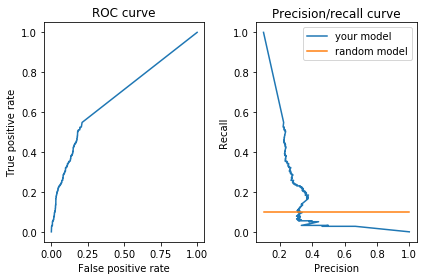

In [30]:
model = torch.load('models/1_1.pt')
all_outputs, all_labels = test_model(model, nn.CrossEntropyLoss())
summarize(all_outputs, all_labels)

# 1_2 VGG-19
Here we add a classifier on top of VGG-19 with the hope of extracting higher-level lesion features.

In [7]:
model = models.vgg19(pretrained=False)

for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier[-1].in_features

model.classifier[6] = nn.Linear(in_features, 2)
model = model.cuda()

criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1,6]).to(device))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Test Loss: 12592.7018 Acc: 0.8959
True negatives: 1927
False positives: 28
False negatives: 198
True positives: 19
Area under ROC curve: 0.7400285219277051


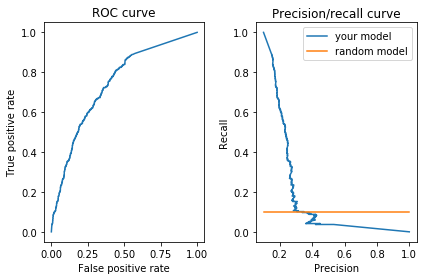

In [27]:
model = torch.load('models/1_2.pt')
all_outputs, all_labels = test_model(model, nn.CrossEntropyLoss())
summarize(all_outputs, all_labels)

# 1_3 VGG-19
Here, we switch to the Adam optimizer.

In [15]:
model = models.vgg19(pretrained=False)

for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier[-1].in_features

model.classifier[6] = nn.Sequential(
                      nn.Linear(in_features, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 2))

model = model.cuda()

criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1,7.375]).to(device))
optimizer = optim.Adam(model.parameters())


In [ ]:
train_model(model, criterion, optimizer, num_epochs=25, chunks=9)

Test Loss: 1423.8181 Acc: 0.9001
True negatives: 1955
False positives: 0
False negatives: 217
True positives: 0
Area under ROC curve: 0.5


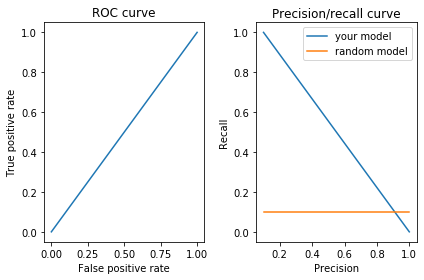

In [28]:
model = torch.load('models/1_3.pt')
all_outputs, all_labels = test_model(model, nn.CrossEntropyLoss())
summarize(all_outputs, all_labels)

# 1_4 VGG-19
Instead of adding a classifier on top of VGG-19, here we unfreeze more of its existing layers.

In [21]:
model = models.vgg19(pretrained=False)

for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier[-1].in_features

model.classifier[6] = nn.Linear(in_features, 2)

model = model.cuda()

criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1,5.5]).to(device))
optimizer = optim.Adam(model.parameters())


In [22]:
for i in range(3,7):
    for parameter in model.classifier[i].parameters():
        parameter.requires_grad = True

In [23]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

139,578,434 total parameters.
16,789,506 training parameters.


Test Loss: 2281.8093 Acc: 0.9001
True negatives: 1955
False positives: 0
False negatives: 217
True positives: 0
Area under ROC curve: 0.724869470930027


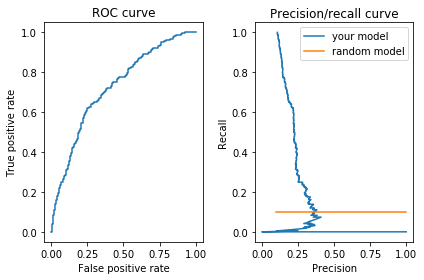

In [29]:
model = torch.load('models/1_4.pt')
all_outputs, all_labels = test_model(model, nn.CrossEntropyLoss())
summarize(all_outputs, all_labels)